In [40]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam 
import torchvision 
from torchvision import transforms, datasets 
from torch.utils.data import DataLoader, random_split 
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
import os
from tqdm import tqdm

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256 
CHANNELS = 3
EPOCHS = 50

In [4]:
resize_and_rescale = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize to 256x256.
    transforms.ToTensor() # Convert PIL Image to tensor and scale to [0,1].
])

In [5]:
dataset = datasets.ImageFolder(
    root="PlantVillage",
    transform=resize_and_rescale
)

print(f"Found {len(dataset)} images belonging to {len(dataset.classes)} classes.")
class_names = dataset.classes 
print(f"Classes: {class_names}")

Found 4500 images belonging to 3 classes.
Classes: ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


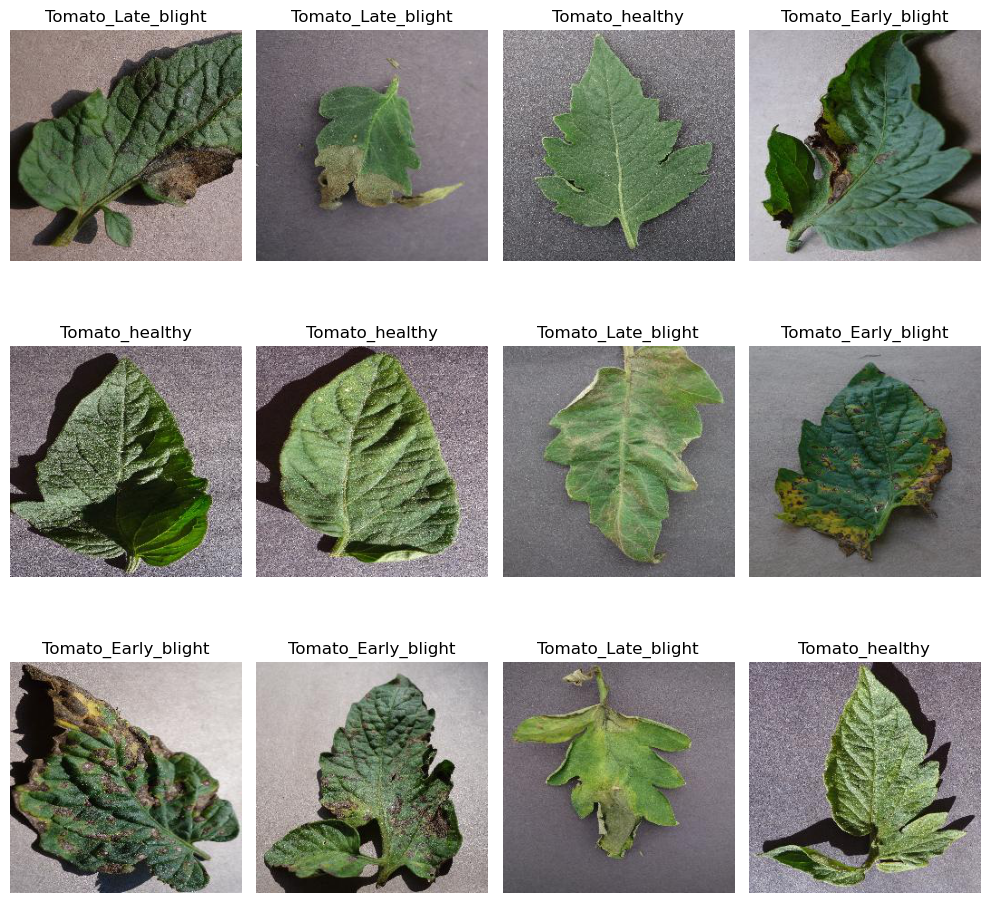

In [6]:
def visualise_dataset(dataset, class_names, num_images=12):
    temp_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(temp_loader))

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # PyTorch uses CHW but Matplotlib expects HWC,
        # so we change the order.
        img = images[i].permute(1, 2, 0).numpy() 

        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualise_dataset(dataset, class_names)

In [7]:
def get_dataset_partitions_pytorch(dataset, train_split=0.8, val_split=0.1, test_split=0.1):
    dataset_size = len(dataset)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size 

    print(f"Dataset split-------")
    print(f"Total samples: {dataset_size}")
    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    print(f"Test samples: {test_size}")

    train_dataset, val_dataset, test_dataset = random_split(
        dataset, 
        [train_size, val_size, test_size],
        generator = torch.Generator().manual_seed(17)
    )

    return train_dataset, val_dataset, test_dataset

In [8]:
# Augmentation to get more varied training samples 
# so our model can be more robust.
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor()
])



In [9]:
train_dataset_augmented = datasets.ImageFolder(
    root="PlantVillage",
    transform=train_transform
)

val_test_dataset = datasets.ImageFolder(
    root="PlantVillage",
    # Just basic preprocessing for val and test, no augmentation needed.
    transform=resize_and_rescale
)

# Split the augmented training dataset and non-augmented val and test dataset
train_dataset_aug, _, _ = get_dataset_partitions_pytorch(train_dataset_augmented)
_, val_dataset_clean, test_dataset_clean = get_dataset_partitions_pytorch(val_test_dataset)

Dataset split-------
Total samples: 4500
Training samples: 3600
Validation samples: 450
Test samples: 450
Dataset split-------
Total samples: 4500
Training samples: 3600
Validation samples: 450
Test samples: 450


In [10]:
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset_clean,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

test_loader = DataLoader(
    test_dataset_clean,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 113
Number of validation batches: 15
Number of test batches: 15


In [11]:
# for images, labels in train_loader:
#     print(f"Training batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
#     print(f"Sample labels: {labels[:10].numpy()}")
#     break

# for images, labels in val_loader:
#     print(f"Validation batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
#     break

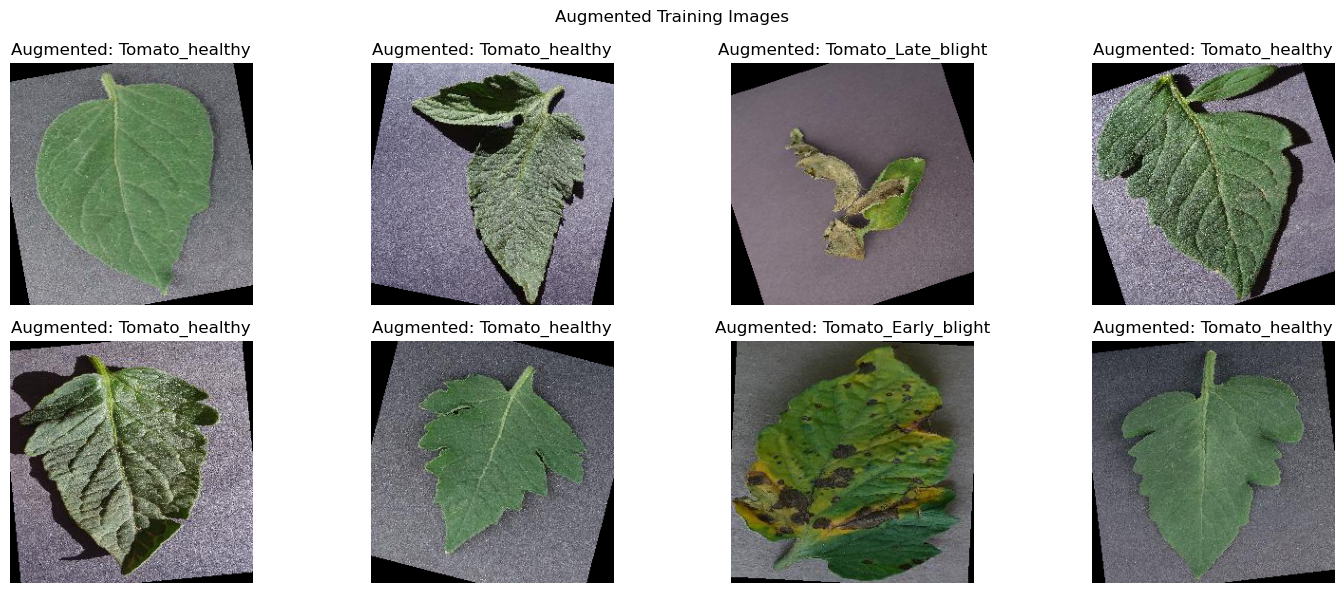

In [12]:
def visualise_augmentation(dataset, class_names, num_images=8):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))
    
    plt.figure(figsize=(15, 6))
    for i in range(min(num_images, 8)):
        ax1 = plt.subplot(2, 4, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Augmented: {class_names[labels[i]]}")
        plt.axis("off")
    
    plt.suptitle("Augmented Training Images")
    plt.tight_layout()
    plt.show()

visualise_augmentation(train_dataset_aug, class_names)

In [22]:
class PotatoCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(PotatoCNN, self).__init__()

        self.features = nn.Sequential(
            # Because of padding, nn.Conv2d outputs the same image size.
            # Size of image halves after every call of nn.MaxPool2d.
            
            # Image is size 256 * 256
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Image is size 128 * 128
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Image is size 64 * 64
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Image is size 32 * 32
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Image is size 16 * 16
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Image is size 8 * 8
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),

            # Final image is size 4 * 4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 64), # 64 channels with 4 * 4 final image size
            nn.ReLU(True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, 3, 256, 256)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        x = self.features(x)
        x = self.classifier(x)
        return x

In [23]:
n_classes = len(class_names)
model = PotatoCNN(num_classes=n_classes).to(device)

In [24]:
print("Model Architecture:")
print(model)

Model Architecture:
PotatoCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [25]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 232,899
Trainable parameters: 232,899


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [30]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    Train the model and track training/validation metrics

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        epochs: Number of training epochs
    
    Returns:
        Dictionary containing training history
    """

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            # Empty the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)   
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            train_pbar.set_postfix({
                "Loss": f'{loss.item():.4f}',
                "Acc": f'{100. * train_correct / train_total:.2f}%'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*val_correct/val_total:.2f}%'
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        
        # Store metrics in history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}]:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        print('-' * 60)

    return history

In [31]:
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Starting training...


Epoch 1/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it, Loss=0.1204, Acc=79.78%]


Epoch [1/30]:
  Train Loss: 0.7201, Train Acc: 65.50%
  Val Loss: 0.4118, Val Acc: 79.78%
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.99s/it, Loss=0.0446, Acc=78.89%]


Epoch [2/30]:
  Train Loss: 0.4539, Train Acc: 80.44%
  Val Loss: 0.4939, Val Acc: 78.89%
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it, Loss=0.0271, Acc=81.78%]


Epoch [3/30]:
  Train Loss: 0.4098, Train Acc: 83.53%
  Val Loss: 0.3759, Val Acc: 81.78%
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0112, Acc=86.67%]


Epoch [4/30]:
  Train Loss: 0.3395, Train Acc: 85.92%
  Val Loss: 0.2850, Val Acc: 86.67%
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it, Loss=0.0108, Acc=79.33%]


Epoch [5/30]:
  Train Loss: 0.2934, Train Acc: 89.47%
  Val Loss: 0.4180, Val Acc: 79.33%
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0022, Acc=89.78%]


Epoch [6/30]:
  Train Loss: 0.2884, Train Acc: 89.17%
  Val Loss: 0.2258, Val Acc: 89.78%
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it, Loss=0.0229, Acc=88.89%]


Epoch [7/30]:
  Train Loss: 0.2751, Train Acc: 89.92%
  Val Loss: 0.2699, Val Acc: 88.89%
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0013, Acc=81.78%]


Epoch [8/30]:
  Train Loss: 0.2409, Train Acc: 91.28%
  Val Loss: 0.4866, Val Acc: 81.78%
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it, Loss=0.0004, Acc=91.33%]


Epoch [9/30]:
  Train Loss: 0.2449, Train Acc: 90.17%
  Val Loss: 0.2336, Val Acc: 91.33%
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it, Loss=0.0002, Acc=92.00%]


Epoch [10/30]:
  Train Loss: 0.2198, Train Acc: 91.83%
  Val Loss: 0.1798, Val Acc: 92.00%
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it, Loss=0.0001, Acc=91.33%]


Epoch [11/30]:
  Train Loss: 0.1978, Train Acc: 92.67%
  Val Loss: 0.2033, Val Acc: 91.33%
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.96s/it, Loss=0.0015, Acc=94.00%]


Epoch [12/30]:
  Train Loss: 0.2527, Train Acc: 89.81%
  Val Loss: 0.1933, Val Acc: 94.00%
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it, Loss=0.0001, Acc=95.11%]


Epoch [13/30]:
  Train Loss: 0.1832, Train Acc: 93.00%
  Val Loss: 0.1377, Val Acc: 95.11%
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0001, Acc=94.44%]


Epoch [14/30]:
  Train Loss: 0.1953, Train Acc: 92.61%
  Val Loss: 0.1494, Val Acc: 94.44%
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it, Loss=0.0001, Acc=93.56%]


Epoch [15/30]:
  Train Loss: 0.1754, Train Acc: 93.25%
  Val Loss: 0.1566, Val Acc: 93.56%
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0000, Acc=95.11%]


Epoch [16/30]:
  Train Loss: 0.1559, Train Acc: 94.33%
  Val Loss: 0.1163, Val Acc: 95.11%
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.98s/it, Loss=0.0001, Acc=92.67%]


Epoch [17/30]:
  Train Loss: 0.1930, Train Acc: 92.39%
  Val Loss: 0.1857, Val Acc: 92.67%
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0004, Acc=93.56%]


Epoch [18/30]:
  Train Loss: 0.1537, Train Acc: 94.31%
  Val Loss: 0.1611, Val Acc: 93.56%
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0001, Acc=93.78%]


Epoch [19/30]:
  Train Loss: 0.1397, Train Acc: 94.36%
  Val Loss: 0.1456, Val Acc: 93.78%
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0002, Acc=90.00%]


Epoch [20/30]:
  Train Loss: 0.1152, Train Acc: 95.61%
  Val Loss: 0.2136, Val Acc: 90.00%
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0001, Acc=92.44%]


Epoch [21/30]:
  Train Loss: 0.1290, Train Acc: 95.17%
  Val Loss: 0.1768, Val Acc: 92.44%
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0000, Acc=96.67%]


Epoch [22/30]:
  Train Loss: 0.1293, Train Acc: 94.94%
  Val Loss: 0.0946, Val Acc: 96.67%
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0051, Acc=95.56%]


Epoch [23/30]:
  Train Loss: 0.1362, Train Acc: 94.72%
  Val Loss: 0.1248, Val Acc: 95.56%
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0001, Acc=94.67%]


Epoch [24/30]:
  Train Loss: 0.0999, Train Acc: 96.08%
  Val Loss: 0.1310, Val Acc: 94.67%
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 15/15 [1:12:14<00:00, 288.96s/it, Loss=0.0000, Acc=93.11%]


Epoch [25/30]:
  Train Loss: 0.0882, Train Acc: 97.03%
  Val Loss: 0.1625, Val Acc: 93.11%
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.92s/it, Loss=0.0001, Acc=96.22%]


Epoch [26/30]:
  Train Loss: 0.1078, Train Acc: 95.50%
  Val Loss: 0.1017, Val Acc: 96.22%
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0002, Acc=95.33%]


Epoch [27/30]:
  Train Loss: 0.1397, Train Acc: 95.00%
  Val Loss: 0.1139, Val Acc: 95.33%
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0002, Acc=96.89%]


Epoch [28/30]:
  Train Loss: 0.0762, Train Acc: 97.03%
  Val Loss: 0.1031, Val Acc: 96.89%
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 15/15 [00:29<00:00,  1.94s/it, Loss=0.0004, Acc=96.22%]


Epoch [29/30]:
  Train Loss: 0.0966, Train Acc: 96.36%
  Val Loss: 0.1149, Val Acc: 96.22%
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 15/15 [00:28<00:00,  1.93s/it, Loss=0.0000, Acc=93.11%]

Epoch [30/30]:
  Train Loss: 0.0769, Train Acc: 97.31%
  Val Loss: 0.1508, Val Acc: 93.11%
------------------------------------------------------------


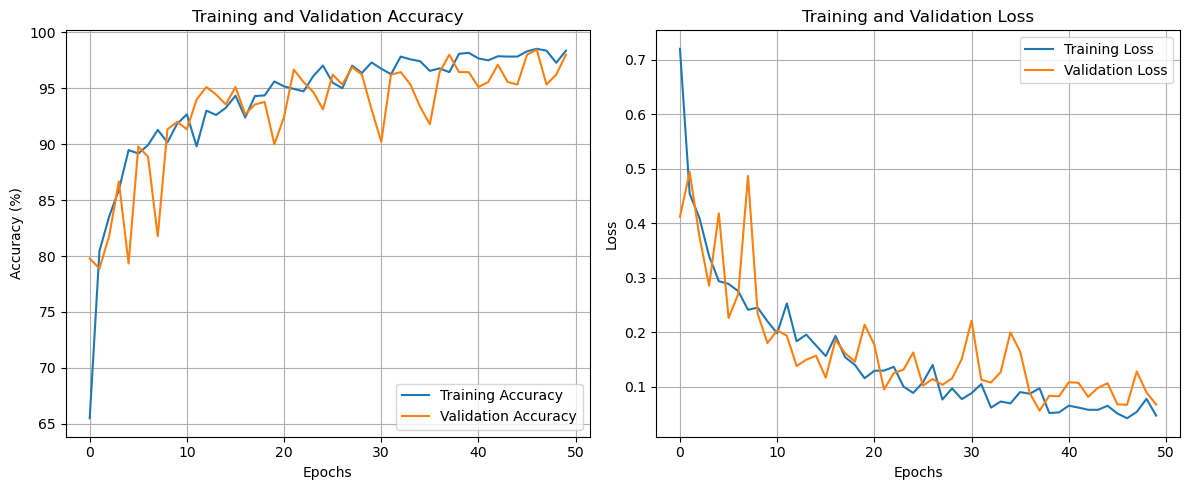

In [57]:
def plot_training_history(history):
    """
    Plot training and validation accuracy/loss curves

    Args:
        history: Dictionary containing training metrics
    """
    epochs_range = range(len(history['train_loss']))

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [62]:
def evaluate_model(model, test_loader, criterion):
    """
    Evaluate model performance on test set

    Args:
        model: Trained model
        test_loader: Test data loader
        criterion: Loss function
    
    Returns:
        test_loss, test_accuracy
    """
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * test_correct / test_total 

    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

Testing: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it]

Test Loss: 0.2257
Test Accuracy: 97.11


In [63]:
def predict_single_image(model, image_tensor, class_names):
    """ 
    Make prediction on a single image

    Args:
        model: Trained model
        image_tensor: Image tensor of shape (C, H, W)
        class_names: List of class names
    
    Returns:
        predicted_class, confidence
    """
    model.eval()

    # Add batch dimension: (C, H, W) -> (1, C, H, W)
    image_batch = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_batch)
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        predicted_class = class_names[predicted.item()]
        confidence_score = confidence.item() * 100
    
    return predicted_class, confidence_score 

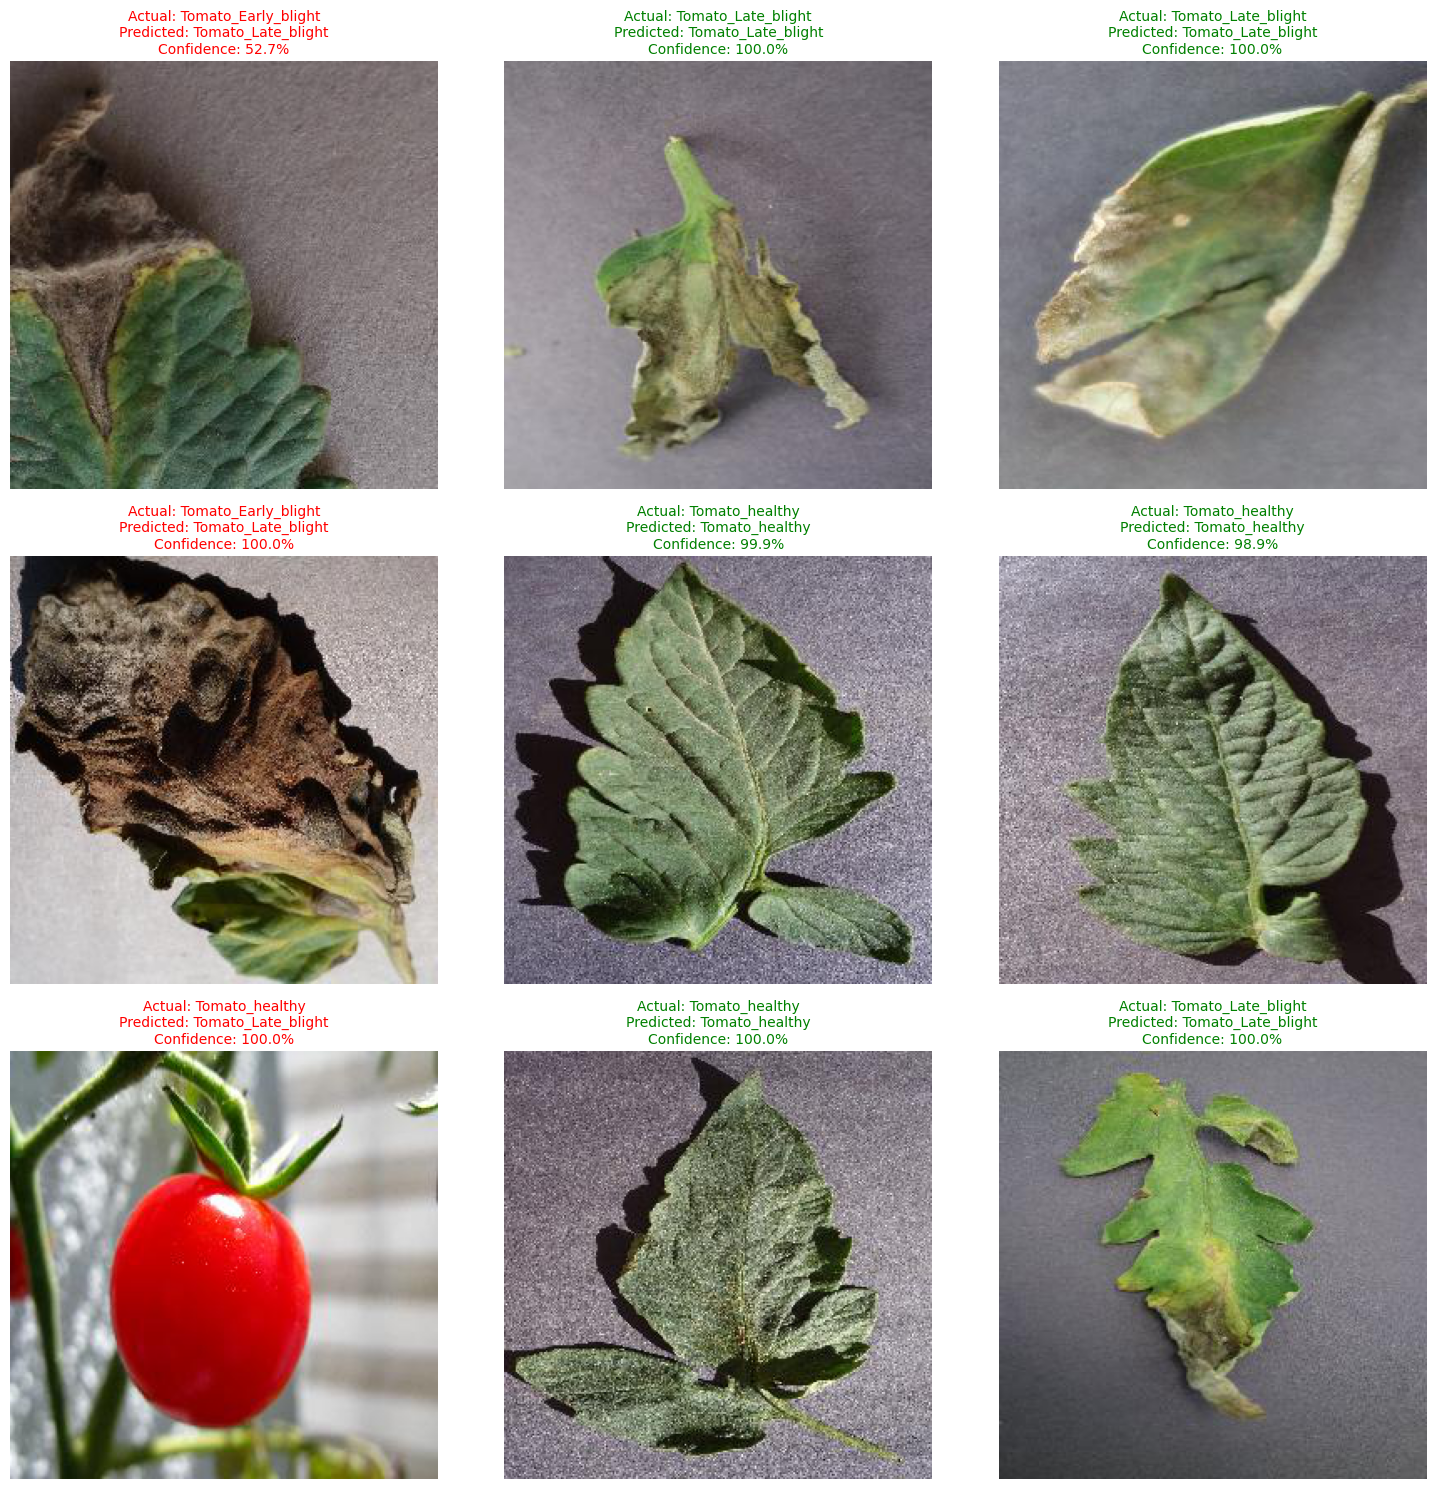

In [64]:
def visualise_predictions(model, test_loader, class_names, num_images=9):
    """
    Visualise model predictions on test images

    Args:
        model: Trained model
        test_loader: Test data loader
        class_names: List of class names
        num_images: Number of images to display
    """
    model.eval()

    images, labels = next((iter(test_loader)))

    plt.figure(figsize=(15, 15))

    for i in range(min(num_images, len(images))):
        # Make prediction
        predicted_class, confidence = predict_single_image(model, images[i], class_names)
        actual_class = class_names[labels[i]]

        # Display image
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)

        # Set title with prediction results
        color = 'green' if predicted_class == actual_class else 'red'
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.1f}%", 
                 color=color, fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualise_predictions(model, test_loader, class_names)

In [51]:
def save_model(model, model_dir="models", model_name="potato_cnn"):
    """
    Save the trained model
    
    Args:
        model: Trained model
        model_dir: Directory to save model
        model_name: Base name for the model
    """
    # Create models directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Get next version number
    existing_models = [f for f in os.listdir(model_dir) if f.startswith(model_name)]
    if existing_models:
        versions = []
        for model_file in existing_models:
            try:
                # Extract version number from filename
                version = int(model_file.split('_v')[-1].split('.')[0])
                versions.append(version)
            except:
                continue
        next_version = max(versions) + 1 if versions else 1
    else:
        next_version = 1
    
    model_path = os.path.join(model_dir, f"{model_name}_v{next_version}.pth")
    
    # Save both model state and architecture info
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': model.__class__.__name__,
        'num_classes': len(class_names),
        'class_names': class_names,
        'image_size': IMAGE_SIZE,
        'test_accuracy': test_accuracy
    }, model_path)
    
    print(f"Model saved to: {model_path}")

# Save the trained model
save_model(model)

Model saved to: models/potato_cnn_v2.pth


In [67]:
def load_model(model_path, device):
    """
    Load a saved model
    
    Args:
        model_path: Path to saved model
        device: Device to load model on
    
    Returns:
        Loaded model and metadata
    """
    checkpoint = torch.load(model_path, map_location=device)
    
    # Recreate model architecture
    num_classes = checkpoint['num_classes']
    model = PotatoCNN(num_classes=num_classes)
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    return model, checkpoint

# Loading the model 
model, metadata = load_model("models/potato_cnn_v1.pth", device)
print(f"Loaded model!")

Loaded model!


In [71]:
model_30, metadata_30 = load_model("models/potato_cnn_v1.pth", device)
model_50, metadata_50 = load_model("models/potato_cnn_v2.pth", device)

test_loss_30, test_acc_30 = evaluate_model(model_30, test_loader, criterion)
test_loss_50, test_acc_50 = evaluate_model(model_50, test_loader, criterion)

print("Model Comparison on Test Set:")
print(f"30-epoch model: {test_acc_30:.2f}% accuracy")
print(f"50-epoch model: {test_acc_50:.2f}% accuracy")

Testing: 100%|██████████| 15/15 [00:29<00:00,  1.95s/it]

Model Comparison on Test Set:
30-epoch model: 95.56% accuracy
50-epoch model: 97.11% accuracy
